*Projet HumanForYou*

**Introduction**

Dans le cadre de notre projet, nous devions pouvoir prédire l'attrition des employés, c'est à dire savoir à l'avance si un employé est susceptible de partir ou non. 
Cette prédiction est basée sur un fichier de donnée. L'objectif est donc de créer/entrainer un modèle permettant cette prédiction.
Comme le but est de définir si oui (1) ou non (0) l'employé part, notre choix s'est tourné vers un modèle de classification, un choix plus adapté aux problèmes où la variable cible est binaire.
Nous avons choisi ici de tester 3 modèles différents:

- Perceptron : modèle efficace pour la classification binaire, il permet un apprentissage itératif
- Decision Tree (classifier): Le modèle est populaire pour ce type de prédiction, il nous a semblé donc pertinent de l'essayer
- Random Forest (classifier): Le modèle est populaire pour ce type de prédiction, il nous a semblé donc pertinent de l'essayer

A la suite des entrainements sur un même jeu de donnée, les 3 algorithmes seront évalués à l'aide de différentes metriques.
À travers ces différentes approches, nous cherchons à obtenir un modèle performant et fiable, capable d'aider  à mieux anticiper le départ d'un employé et à mettre en place des stratégies adaptées pour améliorer la rétention du personnel.

Notre but est de minimiser également le taux de faux positif.  En effet, un faux positif signifierait qu'un employé est identifié à tort comme susceptible de partir, ce qui entraînerait des investissements inutiles en termes de ressources et de temps pour éviter son départ.

**Code**

In [20]:
import os
import pandas as pd
import numpy as np
import joblib

In [21]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

In [22]:

class AttritionModel:
    def __init__(self, data_path):
        """
        Initialise l'objet avec le chemin des données et définit les attributs nécessaires.

        Entrée :
        - data_path (str) : Chemin du fichier contenant les données.
        """
        self.data_path = data_path
        self.current_working_directory = os.getcwd()
        self.numerical_columns = []
        self.categorical_columns = []
        self.full_pipeline = None
        self.models = {}
        self.tab_mean = []
    
    def load_data(self):
        """
        Charge les données depuis un fichier Excel et récupère les données dans des variables afin des les traiter plus tard dans une Pipeline

        En accord avec notre rapport ethique, on supprime les variables considéré non utile pour notre analyse: 
        'EmployeeNumber', 'Over18', 'EmployeeCount'
        Sortie :
        - Initialise les attributs :
            - self.X (pd.DataFrame) : Variables explicatives après suppression de certaines colonnes inutiles.
            - self.y (pd.Series) : Variable cible (Attrition) convertie en valeurs numériques.
            - self.numerical_columns (list) : Liste des colonnes numériques.
            - self.categorical_columns (list) : Liste des colonnes catégorielles.
        """
        df = pd.read_excel(self.data_path)
        self.X = df.drop(columns=['EmployeeNumber', 'Attrition', 'Over18', 'EmployeeCount'], axis=1) 
        self.y = df['Attrition'].map({'Yes': 1, 'No': 0}) #Transforme Attrition en colonne numérique, permet de simplifier le traitement
        self.numerical_columns = self.X.select_dtypes(include=['float64', 'int64']).columns.tolist() #Récupere la liste des colonnes numériques
        self.categorical_columns = self.X.select_dtypes(include=['object']).columns.tolist() #Récupere la liste des colonnes catégorielle
        
    def split_data(self, test_size=0.2, random_state=42):
        """
        Créer deux jeux de données, le premier pour l'entrainement et le second permettra de tester le model
        pour faire une évaluation de celui-ci

        Entrée :
        - test_size: Portion du dataset en test, soit 80% entrainement et 20% pour les tests
        - random_state: controler l'aléatoire dans la prise des données afin de toujours avoir les mêmes données selectionnées et ne pas fausser les résultats
        Sortie :
        - self.X_train : Colonne d'entrainement contenant tout les colonnes (excepté celle enlevé)
        - self.X_test : Colonne de test contenant tout les colonnes (excepté celle enlevé)
        - self.y_train :Colonne d'entrainement contenant uniquement Attrition
        - self.y_test : Colonne de test contenant uniquement Attrition (utilisé uniquement pour faire des metriques en comparant les résultat prédit avec les réels).
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state
        ) 
    
    def build_pipeline(self):
        """
        Construit un pipeline de transformation des données pour les colonnes numériques et catégorielles.
        
        Utilisation de SimpleImputer afin de remplacer les valeurs inconnues par soit:
        colonne numerique: mediane, (utilisable uniquement avec des données numériques, permet d'avoir une valeur homogène à l'ensemble)
        colonne catégorielle: Valeur la plus fréquente (Permet de rester cohérent avec le reste des valeurs)

        OneHotEncoder, permet d'encoder les colonnes catégorielle en colonne numérique pour être exploitable par notre modèle 
        Il sépare les valeurs des colonnes categorielles en créant des colonnes binaires (1 si l'attribue est présent, 0 si non) 

        Standard Scaler permet de mettre toute les valeurs sur la même echelle afin d'équilibrer l'important de chaque valeur 
        Sortie :
        - Initialise l'attribut :
            - self.full_pipeline (ColumnTransformer) : Pipeline de transformation des données.
        """
        #Pipeline pour les transformations numérique 
        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('std_scaler', StandardScaler())
        ])
        #Pipeline pour les transformations catégorielle 
        cat_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        
        #Redefinition de variable
        # self.numerical_columns = self.X.select_dtypes(include=['number']).columns.tolist()
        # self.categorical_columns = self.X.select_dtypes(include=['object']).columns.tolist()
        
        #Pipeline principale appelant les deux précédentes en même temps
        self.full_pipeline = ColumnTransformer([
            ('num', num_pipeline, self.numerical_columns),
            ('cat', cat_pipeline, self.categorical_columns)
        ])

    def transform_data(self):
        """
        Applique le pipeline de transformation aux données d'entraînement et de test, puis sauvegarde le pipeline.
        la sauvegarde des la pipeline est fait dans l'objectif de réutiliser exactement la même lors de vrais prédiction
        Pour être sûr de n'avoir aucune erreur on peut également enregistrer les colonnes crée par OneHotEncoder.
        Sortie :
        - Enregistre le pipeline (fichier 'full_pipeline.pkl').
        - Initialise les attributs :
            - self.out_train (np.array) : Données transformées d'entraînement.
            - self.out_test (np.array) : Données transformées de test.
        """
        self.full_pipeline.fit(self.X_train) #apprend les paramètres du model à la Pipeline
        pipeline_dir = os.path.join(self.current_working_directory, "pipeline")
        os.makedirs(pipeline_dir, exist_ok=True)
        joblib.dump(self.full_pipeline, os.path.join(pipeline_dir, "full_pipeline.pkl")) #enregistre ces paramètres pour les prédictions
        self.out_train = self.full_pipeline.transform(self.X_train) #Transforme les données d'entrainement via la pipeline 
        self.out_test = self.full_pipeline.transform(self.X_test)
    
    def train_decision_tree(self):
        """
        Entraîne un modèle d'arbre de décision et le sauvegarde.
        
        Sortie :
        - Sauvegarde le modèle entraîné dans le répertoire 'model/DecisionTree.model'.
        - Ajoute le modèle à l'attribut self.models.
        - Ajoute le score moyen de validation croisée à self.tab_mean.
        """
        dt_model = DecisionTreeClassifier()
        dt_model.fit(self.out_train, self.y_train)
        mean_score = self.cross_validate_model(dt_model)
        self.tab_mean.append(mean_score)
        model_dir = os.path.join(self.current_working_directory, "model")
        os.makedirs(model_dir, exist_ok=True)
        joblib.dump(dt_model, os.path.join(model_dir, "DecisionTree.model"))
        self.models["DecisionTree"] = dt_model
        #print(f"Modèle DecisionTree sauvegardé dans {model_dir}/DecisionTree.model avec un score moyen de {mean_score}")

    def train_random_forest(self):
        """
        Entraîne un modèle de forêt aléatoire et le sauvegarde.
        Sortie :
        - Sauvegarde le modèle entraîné dans le répertoire 'model/RandomForest.model'.
        - Ajoute le modèle à l'attribut self.models.
        - Ajoute le score moyen de validation croisée à self.tab_mean.
        """
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(self.out_train, self.y_train)
        mean_score = self.cross_validate_model(rf_model)
        self.tab_mean.append(mean_score)
        model_dir = os.path.join(self.current_working_directory, "model")
        os.makedirs(model_dir, exist_ok=True)
        joblib.dump(rf_model, os.path.join(model_dir, "RandomForest.model"))
        self.models["RandomForest"] = rf_model
        #print(f"Modèle random forest sauvegardé dans {model_dir}/RandomForest.model avec un score moyen de {mean_score}")

    def train_perceptron(self):
        """
        Entraîne un modèle Perceptron et le sauvegarde.
        Sortie :
        - Sauvegarde le modèle entraîné dans le répertoire 'model/Perceptron.model'.
        - Ajoute le modèle à l'attribut self.models.
        - Ajoute le score moyen de validation croisée à self.tab_mean.
        """
        perceptron_model = Perceptron(eta0=0.001, max_iter=10000, penalty='l2', alpha=0.0001)
        perceptron_model.fit(self.out_train, self.y_train)
        mean_score = self.cross_validate_model(perceptron_model)
        self.tab_mean.append(mean_score)
        model_dir = os.path.join(self.current_working_directory, "model")
        os.makedirs(model_dir, exist_ok=True)
        joblib.dump(perceptron_model, os.path.join(model_dir, "Perceptron.model"))
        self.models["Perceptron"] = perceptron_model
        #print(f"Modèle Perceptron sauvegardé dans {model_dir}/Perceptron.model avec un score moyen de {mean_score}")

    def re_train_perceptron(self):
        """
        Entraîne un modèle Perceptron et le sauvegarde.
        Sortie :
        - Sauvegarde le modèle entraîné dans le répertoire 'model/Perceptron.model'.
        - Ajoute le modèle à l'attribut self.models.
        - Ajoute le score moyen de validation croisée à self.tab_mean.
        """
        model_dir = os.path.join(self.current_working_directory, "model")
        if os.path.isdir(os.path.join(model_dir, "Perceptron_retrain.model")):
            pathto_perceptron_model = os.path.join(model_dir, "Perceptron_retrain.model")
        else:
            pathto_perceptron_model = os.path.join(model_dir, "Perceptron.model")
        perceptron_model = joblib.load( pathto_perceptron_model)
        perceptron_model.partial_fit(self.out_train, self.y_train)
        os.makedirs(model_dir, exist_ok=True)
        joblib.dump(perceptron_model, os.path.join(model_dir, "Perceptron_retrain.model"))
        self.models["Perceptron"] = perceptron_model
        #print(f"Modèle Perceptron sauvegardé dans {model_dir}/Perceptron_retrain.model")

    def train_models(self):
        """
        Entraîne tous les modèles disponibles (arbre de décision, forêt aléatoire, perceptron).
        Sortie :
        - Entraîne et sauvegarde tous les modèles.
        """
        self.train_decision_tree()
        self.train_random_forest()
        self.train_perceptron()

    def cross_validate_model(self, model, cv=5):
        """
        permet d'effectuer la cross validation sur l'un des modèles disponible (arbre de décision, forêt aléatoire, perceptron).

        Entrée :
        - model: model parmis ceux disponible, le modèle est a appris les paramètres (.fit)

        Sortie :
        - moyenne des scores de la cross validation
        """
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        scores = cross_val_score(model, self.out_train, self.y_train, cv=kf, scoring='accuracy')
        #print(f"Scores K-Fold Cross-Validation : {scores}")
        #print(f"Score moyen : {np.mean(scores)}")
        return np.mean(scores)

    def evaluate_models(self):
        """
        Évalue les modèles entraînés en utilisant diverses métriques et retourne les résultats sous forme de DataFrame.

        Sortie :
        - results_df (pd.DataFrame) : Résumé des performances des modèles (Accuracy, Precision, Recall, AUC, etc.).
        """
        results = {}
        self.value_roc = []
        i = 0
        for name, model in self.models.items():
            y_pred = model.predict(self.out_test)
            if name == 'Perceptron':
                self.y_probas = model.decision_function(self.out_test)
            else:
                self.y_probas = model.predict_proba(self.out_test)
                self.y_probas = self.y_probas[:, 1]

            self.fpr, self.tpr, self.thresholds = roc_curve(self.y_test, self.y_probas)

            self.value_roc.append(self.fpr)
            self.value_roc.append(self.tpr)

            results[name] = {
                'Accuracy': accuracy_score(self.y_test, y_pred),
                'Precision': precision_score(self.y_test, y_pred),
                'Recall': recall_score(self.y_test, y_pred),
                'AUC':auc(self.fpr, self.tpr),
                'F1 Score': f1_score(self.y_test, y_pred),
                'Conf matrix': confusion_matrix(self.y_test, y_pred),
                'mean_cross_validation':  self.tab_mean[i]
            }
            i=+1

        results_df = pd.DataFrame(results).T
        return results_df

    def load_and_predict(self, model_name, new_data_path):
        """
        Charge un modèle sauvegardé et effectue des prédictions sur de nouvelles données.

        Entrée :
        - model_name (str) : Nom du modèle à charger (ex: 'DecisionTree', 'RandomForest', 'Perceptron').
        - new_data_path (str) : Chemin du fichier Excel contenant les nouvelles données.

        Sortie :
        - predictions (list) : Liste des prédictions effectuées par le modèle.
        """
        model_dir = os.path.join(self.current_working_directory, "model")
        model_path = os.path.join(model_dir, f"{model_name}.model")

        if not os.path.exists(model_path):
            print(f"Le modèle {model_name} n'existe pas dans le répertoire des modèles.")
            return None

        model = joblib.load(model_path)
       # print(f"Modèle {model_name} chargé à partir de {model_path}")

        df = pd.read_excel(new_data_path)
        df = df[self.numerical_columns + self.categorical_columns]

        mapping = {
            "Low": 1,
            "Medium": 2,
            "High": 3,
            "Very High": 4
        }
        if "JobSatisfaction" in df.columns:
            df["JobSatisfaction"] = df["JobSatisfaction"].map(mapping).fillna(0).astype(int)

        new_data_prepared = self.full_pipeline.transform(df)

        predictions = model.predict(new_data_prepared).tolist()

        return predictions

In [23]:
data_path = "data/data_HR.xlsx"
model = AttritionModel(data_path)
model.load_data()
model.split_data()
model.build_pipeline()
model.transform_data()
model.train_models()
print("")
tab_evaluation = model.evaluate_models()
print(tab_evaluation)
print("")
new_data_path = "data/add_data.xlsx"
models_name = ["RandomForest", "Perceptron", "DecisionTree"]

for model_name in models_name:
    predictions = model.load_and_predict(model_name, new_data_path)
    print(f"Prédictions du modèle {model_name}: {predictions}")


              Accuracy Precision    Recall       AUC  F1 Score  \
DecisionTree   0.74902  0.306122  0.333333  0.585714  0.319149   
RandomForest   0.85098       1.0  0.155556  0.835661  0.269231   
Perceptron    0.827451  0.511111  0.511111  0.818201  0.511111   

                        Conf matrix mean_cross_validation  
DecisionTree  [[176, 34], [30, 15]]              0.761847  
RandomForest    [[210, 0], [38, 7]]              0.852381  
Perceptron    [[188, 22], [22, 23]]              0.852381  

Prédictions du modèle RandomForest: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

**Explication des métriques**

Lors de l'étude des modèles, nous avons mis en place plusieurs indicateurs :

*Accuracy (Précision globale)*

L'accuracy mesure la précision globale du modèle. Elle se calcule en faisant le rapport du nombre de bonnes prédictions sur le nombre total d'échantillons.
RandomForest (0.85) > Perceptron (0.83) > DecisionTree (0.74)
On peut donc voir que Random Forest est le plus performant en termes d'exactitude globale.

*Precision*

La précision mesure la proportion des prédictions positives qui sont réellement correctes. Elle se calcule en divisant le nombre de vrais positifs par la somme du nombre de vrais positifs et des faux positifs.
RandomForest (1.0) > Perceptron (0.51) > DecisionTree (0.28)
Là encore, Random Forest est parfait pour éviter les faux positifs.

*Recall*

Le recall mesure le nombre d'occurrences positives détectées par le modèle. Il se calcule en faisant le rapport du nombre de vrais positifs sur la somme des vrais positifs et des faux négatifs.
Perceptron (0.51) > DecisionTree (0.31) > RandomForest (0.16)
Random Forest sacrifie le rappel pour maximiser la précision, ce qui signifie qu'il manque de nombreux cas positifs.

*AUC*

L'AUC mesure la performance de classification du modèle, c'est-à-dire sa capacité à détecter un vrai positif. Plus l'AUC est élevé, meilleur est le modèle.
Dans notre contexte, nous cherchons à minimiser le taux de faux positifs. Ainsi, plus la valeur de l'AUC est élevée, meilleur sera le modèle :
RandomForest (0.84) > Perceptron (0.82) > DecisionTree (0.57)

*F1 Score*

Le F1 score est une métrique globale qui combine la précision et le rappel. Il se calcule comme suit :
F1=2×((Precision+Recall)/(Precision×Recall))
Perceptron (0.51) > DecisionTree (0.29) > RandomForest (0.27)
Le Perceptron offre ici le meilleur compromis entre précision et rappel.

*Matrice de confusion*
La matrice de confusion est une représentation visuelle qui montre les différents taux : vrais positifs, faux positifs, vrais négatifs et faux négatifs.
Dans notre cas :
Decision Tree : Beaucoup de faux positifs et faux négatifs.
Random Forest : Aucun faux positif mais de nombreux faux négatifs.
Perceptron : Bon équilibre entre vrais positifs et faux positifs.

*Validation croisée (Cross Validation)*

La validation croisée est une technique utilisée pour évaluer la performance d’un modèle de manière plus fiable en évitant le sur-apprentissage (overfitting).
RandomForest et Perceptron ont un score similaire (~0.85), ce qui signifie qu'ils sont plus généralisables que l'arbre de décision.

**Conclusion**

*Rappel des résultats*

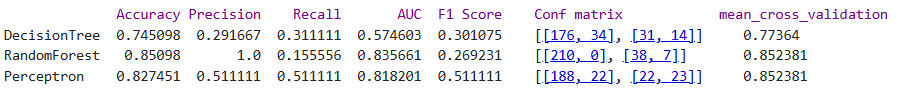

*Analyse des résultats*

L'objectif de cette conclusion est de choisir le modèle ayant le taux de faux positifs le plus faible tout en offrant une performance globale équilibrée.
Si l'on considère uniquement la minimisation des faux positifs, le modèle Random Forest apparaît comme le meilleur choix. Cependant, le Perceptron présente plusieurs avantages majeurs. Contrairement à Random Forest, il peut être réentraîné de manière continue, ce qui lui permet de s'améliorer avec le temps et de mieux s'adapter aux nouvelles données. De plus, il offre un excellent équilibre entre la précision et le rappel, ce qui se traduit par le meilleur score F1 parmi les trois modèles comparés.
Compte tenu de ces éléments, notre choix s'est donc porté sur le Perceptron, qui allie adaptabilité et équilibre des performances.



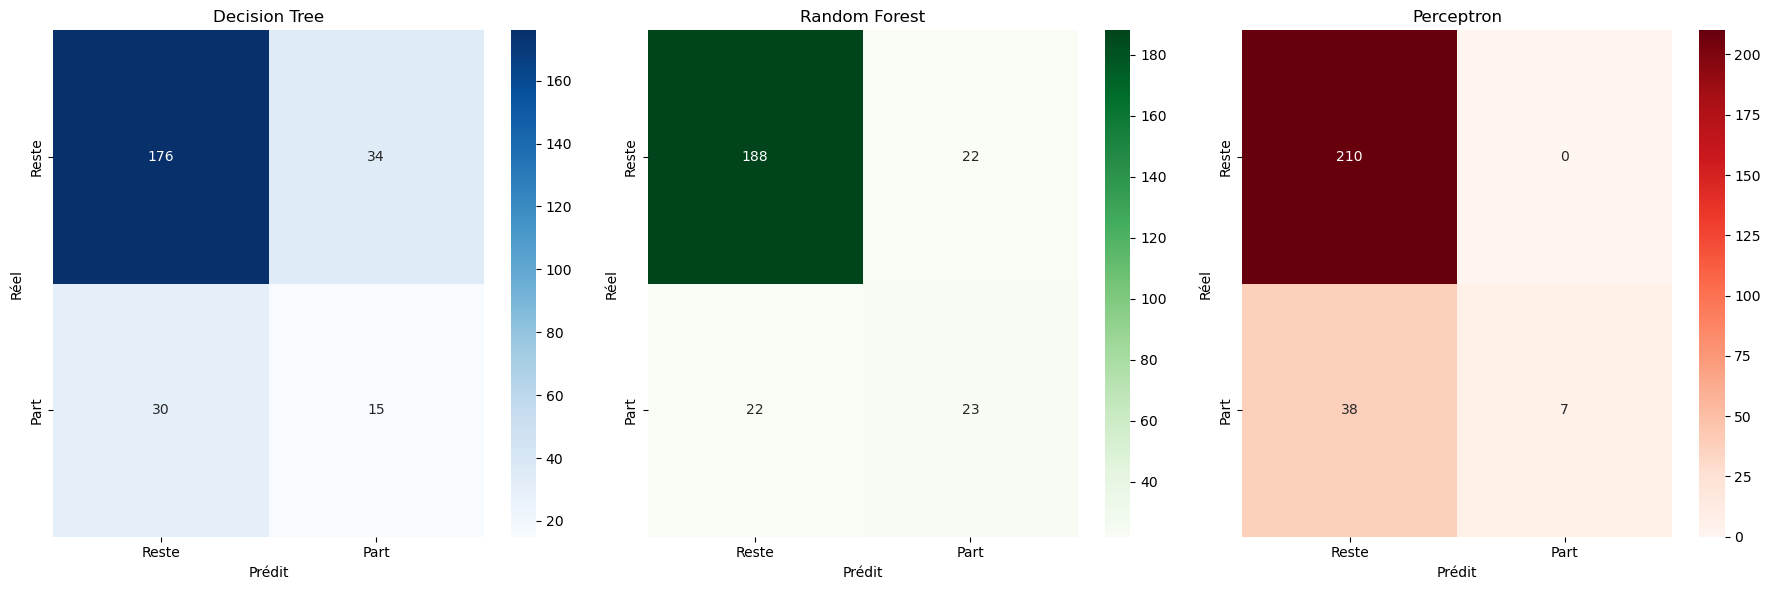

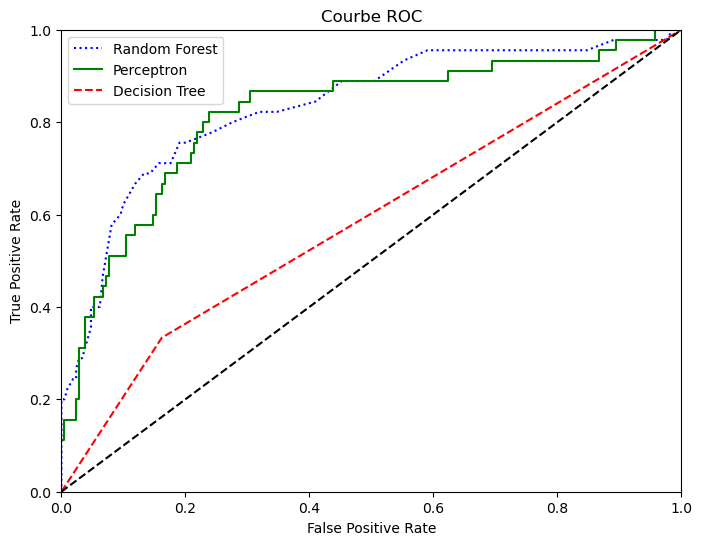

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

evaluation_tab = tab_evaluation.to_numpy()
conf_matrix = {
    "Decision Tree": evaluation_tab[0][5],
    "Perceptron": evaluation_tab[1][5],
    "Random Forest": evaluation_tab[2][5],
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
models = ["Decision Tree", "Random Forest", "Perceptron"]
colors = ["Blues", "Greens", "Reds"]

for ax, model_i, color in zip(axes, models, colors):
    sns.heatmap(conf_matrix[model_i], annot=True, fmt="d", cmap=color, ax=ax)
    ax.set_title(model_i)
    ax.set_xlabel("Prédit")
    ax.set_ylabel("Réel")
    ax.set_xticklabels(["Reste", "Part"])
    ax.set_yticklabels(["Reste", "Part"])

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(model.value_roc[2], model.value_roc[3], "b:", label="Random Forest")
plt.plot(model.value_roc[4], model.value_roc[5], "g-", label="Perceptron")
plt.plot(model.value_roc[0], model.value_roc[1], "r--", label="Decision Tree")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("Courbe ROC")
plt.show()